# РЕТ-проект "Определение жанра по изображению обложки музыкального диска"

## Часть 1: создание baseline-модели

**Цель проекта**: разработать модель, которая определит жанр музыкального альбома по изображению его обложки

**Шаги проекта:** 
- Ознакомление с данными.
- Предварительная обработка данных.
- Определение целевой метрики.
- Подготовка данных для baseline-модели.
- Создание baseline-модели.
- Расчет метрик


## Библиотеки

In [12]:
import os, random
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob, os
import faiss
import torch


# Работа с файлами ZIP
from zipfile import ZipFile

# Открытие изображений
from PIL import Image

from torchvision import datasets, transforms


#Разделение на выборки
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

## Ознакомление с данными

### Изучим папку Anime

#### Оценим количество файлов в папке, средний, максимальны и минимальный размер, а также стандартное отклонение.

In [47]:
with ZipFile("Data/anime.zip", "r") as myzip:
    print("Файлов в папке Anime", len(myzip.infolist()))

Файлов в папке Anime 1190


Напишем функцию для оценки основных характеристик

In [77]:
def zip_info(zip_file):
    zp = zipfile.ZipFile(zip_file)
    print('\033[1m' +"Файлов в папке " + zip_file, len(zp.filelist))
    size = sum([zinfo.file_size for zinfo in zp.filelist])
    zip_kb = float(size)/1000
    print('\033[1m' + 'Размер папки kb ' + zip_file, zip_kb)
    print('\033[1m' +'Средний размер файла kb ', (np.mean([zinfo.file_size for zinfo in zp.filelist])/1000).round(1))
    print('\033[1m' +'Максимальный размер файла kb ',(np.max([zinfo.file_size for zinfo in zp.filelist])/1000).round(1))
    print('\033[1m' +'Минимальный размер файла kb ', (np.min([zinfo.file_size for zinfo in zp.filelist])/1000).round(6))
    print('\033[1m' +'STD размера файла kb ',(np.std([zinfo.file_size for zinfo in zp.filelist])/1000).round(1))
    return  
    
    
    
    

In [78]:
zip_info("Data/anime.zip")

Файлов в папке Data/anime.zip 1190
Размер папки kb Data/anime.zip 203836.931
Средний размер файла kb  171.3
Максимальный размер файла kb  257.5
Минимальный размер файла kb  0.0
STD размера файла kb  37.0


#### Извлечем содержимое папки

In [87]:
os.getcwd()

'/home/jovyan/work/Master_Music'

In [5]:
def extract(name):
    with ZipFile("Data/"+name+".zip", "r") as myzip:
        myzip.extractall('/home/jovyan/work/Master_Music/Data/images/')
    return
    

#### Напечатаем несколько файлов

Напишем функцию для печати 10 файлов из папки

In [171]:
def print_photo(genre):
    for i in range(0,10):
        random_file=random.choice(os.listdir('Data/'+genre+'/'))
        image = Image.open('Data/'+genre+'/'+random_file)
        array = np.array(image)
        plt.imshow(array)
        plt.axis('off')
        plt.show()
    return
    

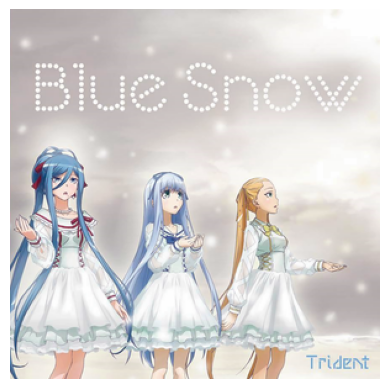

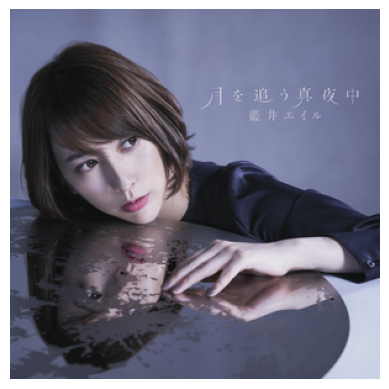

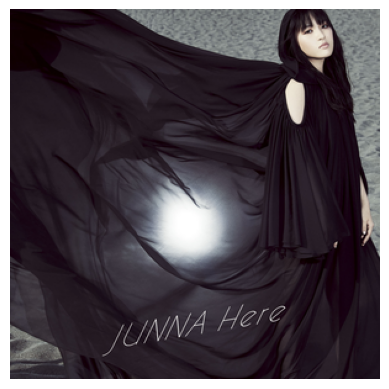

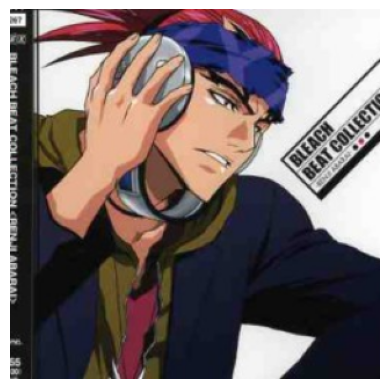

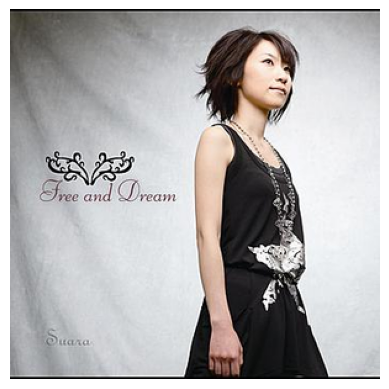

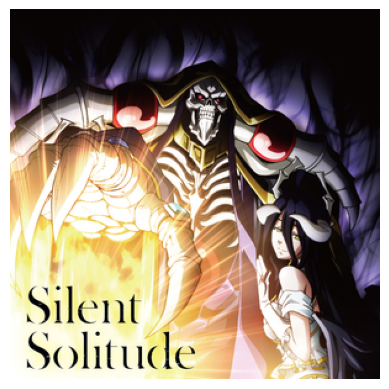

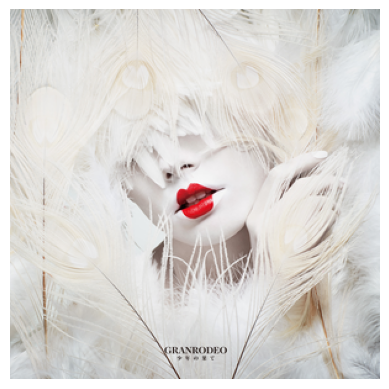

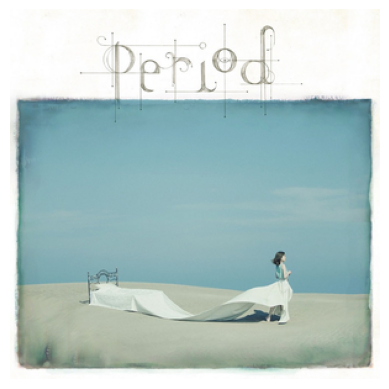

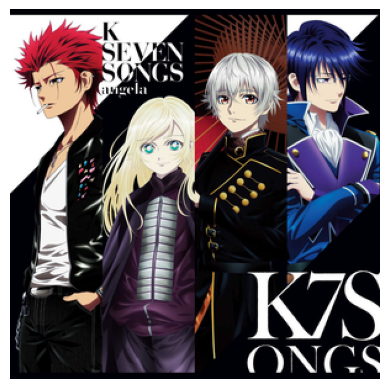

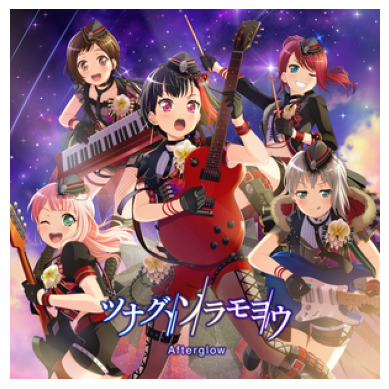

In [172]:
print_photo('anime')

**Промежуточные выводы для папки anime** Изучив данные, можем отметить следующее:
- есть обложки рисованные, есть с фото
- цветовая палитра разнообразная, часто в розовых и голубых тонах, черно-белых обложек не найдено
- на некоторых обложках присутсвует текст
- есть дубликаты

### Изучим папку black metal

In [156]:
#extract('black metal')

#### Оценим количество файлов в папке, средний, максимальны и минимальный размер, а также стандартное отклонение.¶

In [157]:
zip_info("Data/black metal.zip")

Файлов в папке Data/black metal.zip 451
Размер папки kb Data/black metal.zip 74745.506
Средний размер файла kb  165.7
Максимальный размер файла kb  272.5
Минимальный размер файла kb  0.0
STD размера файла kb  51.6


#### Напечатаем несколько файлов

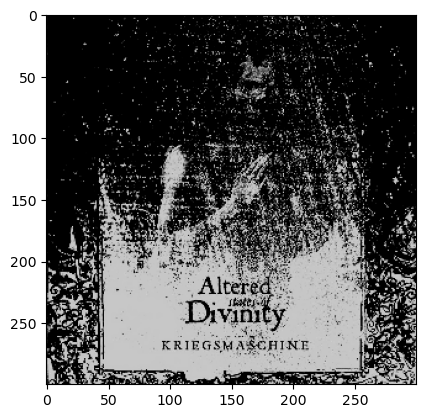

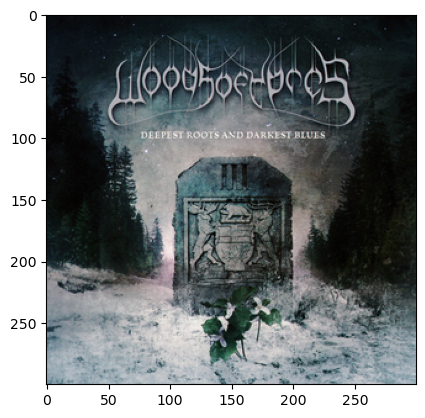

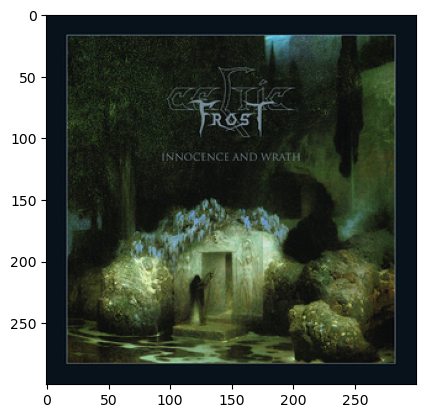

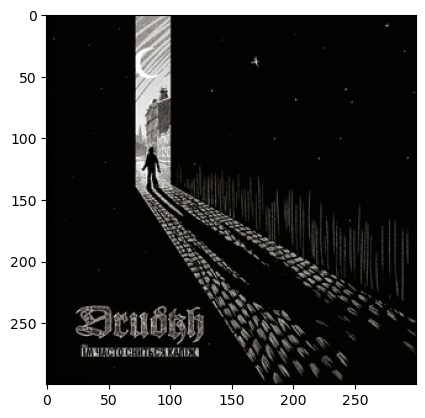

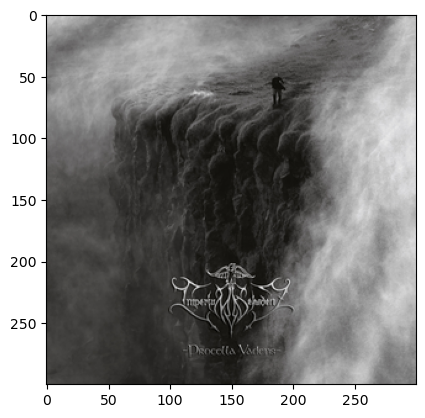

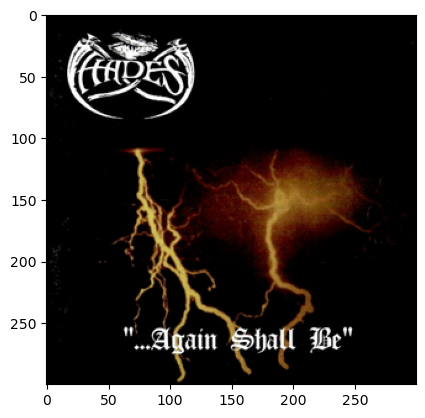

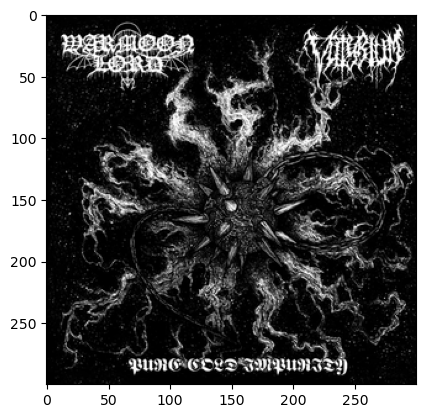

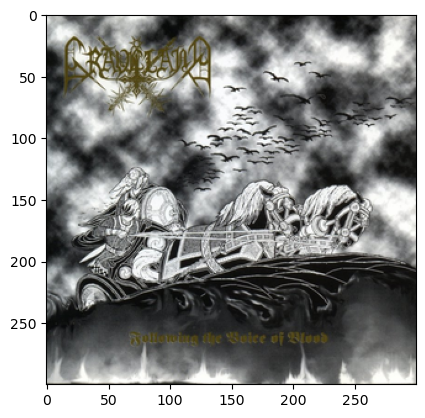

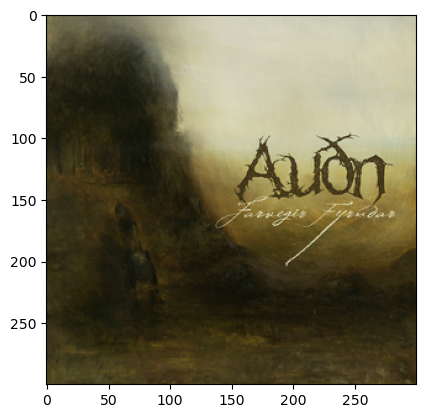

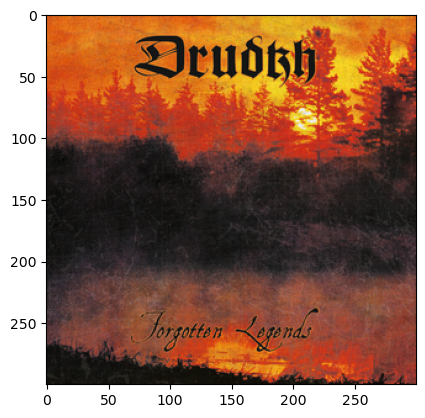

In [161]:
print_photo('black metal')

**Промежуточные выводы для папки black metal** Изучив данные, можем отметить следующее:
- все обложки рисованные
- цветовая палитра темная, есть черно-белые обложки
- на некоторых обложках присутсвует текст

### Изучим папку Classical

In [166]:
#extract('classical')

#### Оценим количество файлов в папке, средний, максимальны и минимальный размер, а также стандартное отклонение.¶

In [167]:
zip_info("Data/classical.zip")

Файлов в папке Data/classical.zip 956
Размер папки kb Data/classical.zip 141863.124
Средний размер файла kb  148.4
Максимальный размер файла kb  254.5
Минимальный размер файла kb  0.0
STD размера файла kb  39.6


#### Напечатаем несколько файлов

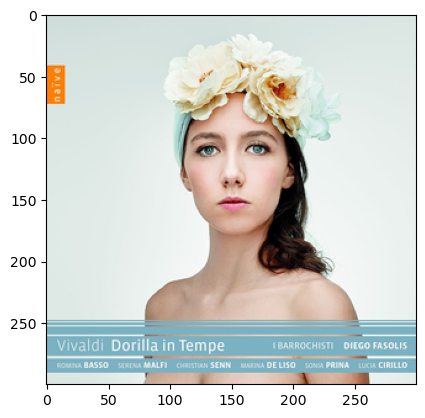

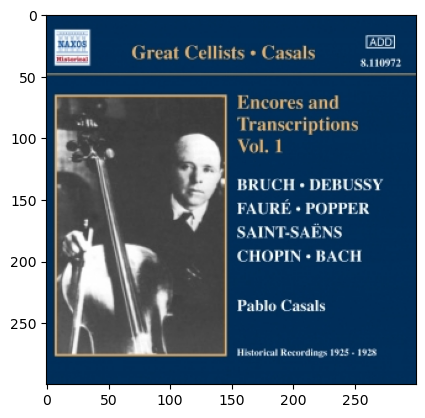

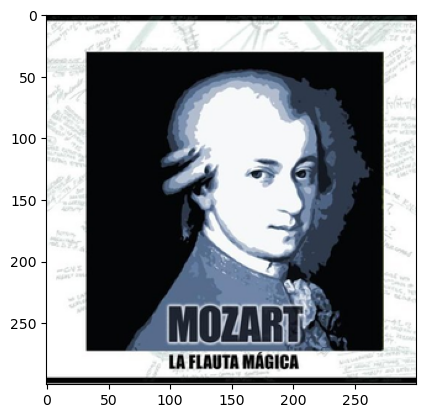

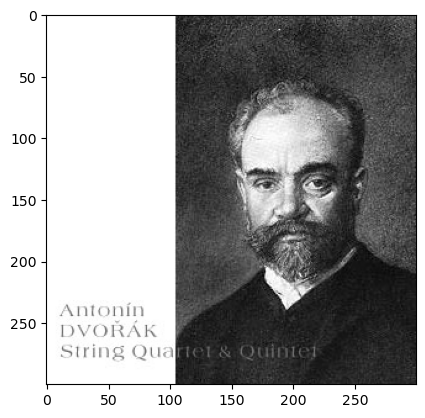

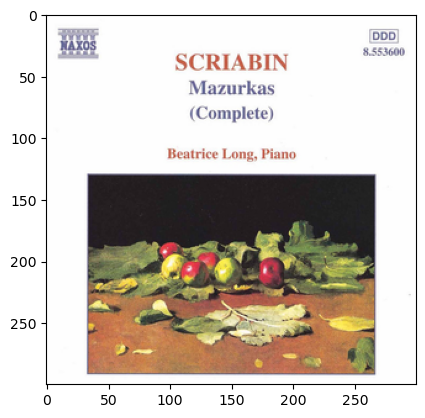

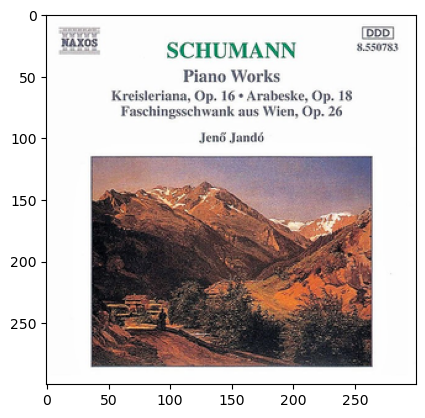

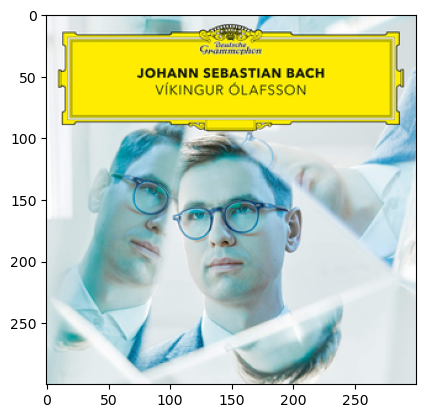

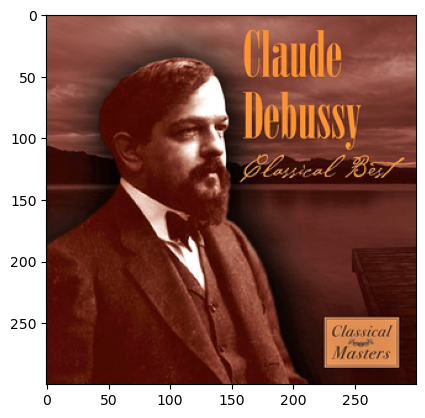

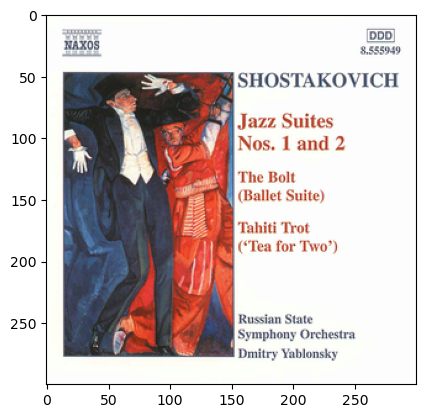

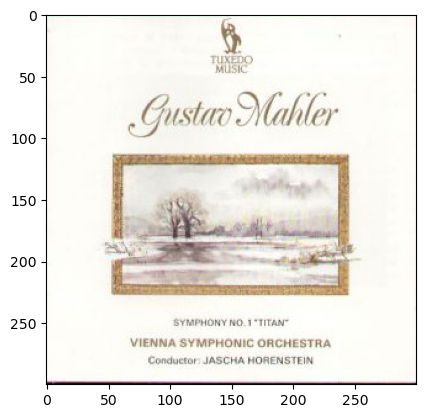

In [170]:
print_photo('classical')

**Промежуточные выводы для папки classical** Изучив данные, можем отметить следующее:
- есть обложки рисованные, есть фото
- на изображении часто лицо или музыкальный инструмент
- цветовая палитра разнообразная, чаще строгая, есть черно-белые изображения
- на некоторых обложках присутсвует текст

#### Извлечем остальные файлы из всех папок

In [24]:
def extract(name):
    with ZipFile("Data/"+name, "r") as myzip:
        myzip.extractall('/home/jovyan/work/Master_Music/Data/images/')
    return

Создадим список зип_файлов

In [25]:
zips = [os.path.basename(f) for f in glob.glob(os.path.join('/home/jovyan/work/Master_Music/Data/', '*.zip'))]
zips

['black metal.zip',
 'country.zip',
 'jazz.zip',
 'rap.zip',
 'disco.zip',
 'reggae.zip',
 'classical.zip',
 'edm.zip',
 'anime.zip',
 'pop.zip']

Извлечем все папки с фото в папку images

In [26]:
for a in zips:
    extract(a)

Создадим список папок с изображениями

In [209]:
folder = '/home/jovyan/work/Master_Music/Data/images'
sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
#sub_folders

### Выведем на экран подборку из 16 изображений всех классов

In [14]:
datagen = ImageDataGenerator()
train_datagen_flow = datagen.flow_from_directory(
    '/home/jovyan/work/Master_Music/Data/images',
    target_size=(300, 300),
  #   color_mode='rgb',
    batch_size=32,
    class_mode='sparse',
 #   subset='training',
    seed=12345)
x, y = next(train_datagen_flow)

Found 7800 images belonging to 10 classes.


Всего рассматриваем 7800 изображений 10 жанров

In [15]:
new1 = pd.Series(train_datagen_flow.class_indices).reset_index()
#new1

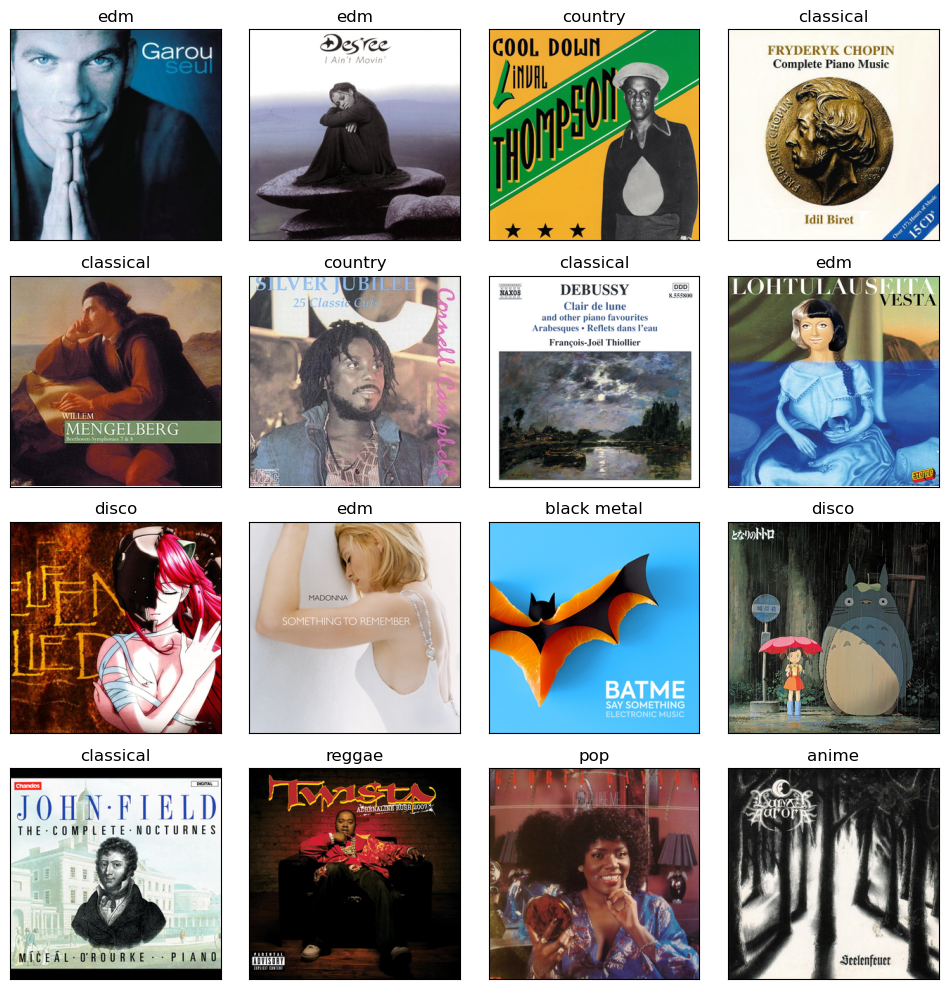

In [41]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
    class_table=pd.Series(train_datagen_flow.class_indices).reset_index()
    fig.add_subplot(4, 4, i+1)
    plt.title(class_names[int(y[i])])
 #   plt.title(class_table.iloc[[(y[i])],0]) # непонятно, как вместо индекса класса прописать назваие класса? Получилось через индексацию, но как-то некрасиво
    plt.imshow(x[i]/255)
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

#### Промежуточные выводы

Мы ознакомились с данными, подробно изучили изображения трех первых жанров, оценили количество изображений каждого жанра и их общее количество. Определенно, некотрые жанры будут выявляться легче других за счет свойственной только им цветовой гамме (anime, black metall), наличию музыкальных инструментов и большего количества текста (classical). Различия между жанрами pop, edm и country слаборазличимы, предполагаем, что выявить их будет сложнее всего. 

## Предварительная обработка данных

Для удобства создадим dataframe с данными, где будут следующие колонки: индекс, название файла, таргет

Напишем функцию для создания таблицы с данными

In [139]:
def data(g, t):
    results = [os.path.basename(f) for f in glob.glob(os.path.join('/home/jovyan/work/Master_Music/Data/images/'+g+'/', '*.png'))]
    pd.DataFrame({'file_name':results, 'target':t})
    return pd.DataFrame({'file_name':results, 'target':t})


In [16]:
name_list = new1['index'].values.tolist()
class_list= new1[0].values.tolist()
#name_list

In [141]:
df_result3 = pd.DataFrame()
for i in range(len(new1)):
    df_temp = data(name_list[i], class_list[i])
    df_result3 = pd.concat([df_result3, df_temp], axis=0)

In [17]:
#df_result3

In [166]:
data = df_result3.reset_index(drop=True)

In [167]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7800 non-null   object
 1   target     7800 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 122.0+ KB


In [168]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [169]:
data.tail(3)

file_name  target
7797  4613c1ad-f235-4306-a48b-78f28f24fd81.png       9
7798  8509d5a0-1108-493e-aa15-7164069f9f23.png       9
7799  6006b201-9641-4f68-8e31-6ff005e2913d.png       9

#### Подготовка данных для baseline-модели

Укажем рабочую директорию и папку с файлами, содержащими фото

In [151]:
def embeddings1(folder):
    data_dir = 'Data/images/'
    list_imgs = glob.glob(data_dir + folder + "/*.png")
 #  print(f"Всего изобраений для классификации {len(list_imgs)} в папке", folder)
    return print(f"Всего изобраений для классификации {len(list_imgs)} в папке", folder)
    
    

In [152]:
embeddings1('anime')

Всего изобраений для классификации 1189 в папке anime


In [153]:
embeddings1('black metal')

Всего изобраений для классификации 450 в папке black metal


In [154]:
embeddings1('classical')

Всего изобраений для классификации 955 в папке classical


## Извлечем эмбеддинги, используя ResNet18

In [228]:
outputs = []
from torchvision import datasets, transforms

def copy_embeddings(m, i, o):  # код взяла из примера, не до конца разобралась, что проиходит в этом месте
    o = o[:, :, 0, 0].detach().numpy().tolist()
    outputs.append(o)

def embeddings(folder):
    data_dir = 'Data/images/'
#    list_imgs = glob.glob(data_dir + folder + "/*.png")
   
    tc = transforms.Compose([   #Приведем фото к нужному формату
        transforms.Resize((256, 256)),
        transforms.ToTensor()              
    ])
    image_datasets = datasets.ImageFolder(root=data_dir, transform=tc)
    dloader = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False)
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18',  pretrained=True)
    layer = model._modules.get('avgpool') # Выберем первый полносвязный слой


    _ = layer.register_forward_hook(copy_embeddings)  # код взяла из примера, не до конца разобралась, что проиходит в этом месте
    #print((list_imgs))
    model.eval()
    for X, y in dloader:
        _ = model(X)
    print(len(image_datasets))
    list_embeddings = [item for sublist in outputs for item in sublist]  # код взяла из примера, не до конца разобралась, что проиходит в этом месте
   #x = np.asarray(list_embeddings)
    return  list_embeddings

In [4]:
#list_emb =embeddings('anime')

Проверим чило эмбеддингов и их размерность

In [260]:
list_emb =embeddings('anime')

7800


In [235]:
len(list_emb)

7800

In [236]:
print(np.array(list_emb[0]).shape) 

(2048,)


Добавим в датасет эмбеддинги

In [237]:
data['emb'] = list_emb

In [238]:
data.tail()

file_name  target  \
7795  3935efe7-590c-46c6-a7f5-d6994a1d1eed.png       9   
7796  9a8a97d0-12dc-4087-b447-57f850792945.png       9   
7797  4613c1ad-f235-4306-a48b-78f28f24fd81.png       9   
7798  8509d5a0-1108-493e-aa15-7164069f9f23.png       9   
7799  6006b201-9641-4f68-8e31-6ff005e2913d.png       9   

                                                    emb  
7795  [0.020657183602452278, 2.1422319412231445, 0.0...  
7796  [0.06688757240772247, 1.0970559120178223, 0.60...  
7797  [0.19705486297607422, 1.7654314041137695, 0.25...  
7798  [0.04561011120676994, 0.9099357724189758, 0.11...  
7799  [0.07613576203584671, 1.5490937232971191, 0.43...

In [239]:
#x1 = np.asarray(list_emb)

In [240]:
data1 = np.array(list_emb)

#### Разделим данные на выборки

In [241]:
#from sklearn.model_selection import StratifiedShuffleSplit
#data1 = np.array(list_emb)
#group_label = np.array([0,  1,2])
#data2= data[["emb"]].to_numpy()

In [242]:
group_label1 = data[["target"]].to_numpy()

In [243]:
x_data = data['emb']
y_data = data['target']

x_train, x_test, y_train, y_test = train_test_split(data1, group_label1, test_size=0.10,random_state=654321, stratify=y_data)

In [244]:
x_train.shape

(7020, 512)

In [245]:
x_test.shape

(780, 512)

In [246]:
y_train.shape

(7020, 1)

## Создадим baseline-модель на основе Faiss

In [247]:
dim = 512  # векторы размерности 512
#np.random.seed(228)

Создадим пустой индекс

In [248]:
index = faiss.IndexFlatL2(dim)
print(index.ntotal)  # пока индекс пустой

0


Создадим индекс на основе тренировочной выборки, равной 70 процентов от всего датасета

In [249]:
index.add(x_train)
print(index.ntotal)

7020


Определим один ближайший индекс и расстояние для тестовой выборки

In [250]:
topn = 1
Distance, Index = index.search(x_test, topn)  # Возвращает результат: Distances, Indices
len(Index)
#Index

780

In [251]:
Index.shape

(780, 1)

Сменим размероность

In [252]:
w = Index.flatten()

In [253]:
w.shape

(780,)

Определим предсказанный класс

In [254]:
y_pred = y_train[w]

#### Рассчитаем метрики для baseline модели Faiss

Создадим список жанров для классов

In [266]:
folder = '/home/jovyan/work/Master_Music/Data/images'
sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
print(name_list)
print(class_list)

['anime', 'black metal', 'classical', 'country', 'disco', 'edm', 'jazz', 'pop', 'rap', 'reggae']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [256]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58       119
           1       0.63      0.60      0.61        45
           2       0.51      0.68      0.58        95
           3       0.46      0.47      0.47       149
           4       0.24      0.21      0.22        47
           5       0.48      0.44      0.46        72
           6       0.30      0.34      0.32        82
           7       0.37      0.28      0.31        80
           8       0.13      0.09      0.11        33
           9       0.31      0.29      0.30        58

    accuracy                           0.44       780
   macro avg       0.40      0.40      0.40       780
weighted avg       0.43      0.44      0.43       780



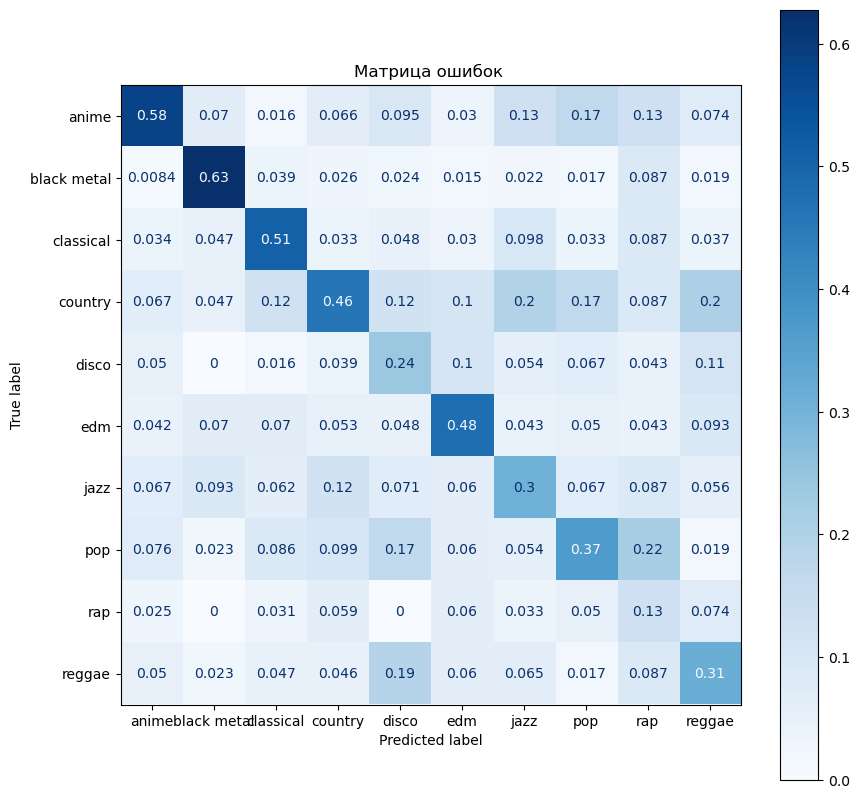

In [263]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize='pred'),
                               display_labels=name_list)
disp.plot(cmap='Blues')
disp.ax_.set_title("Матрица ошибок ")
plt.rcParams["figure.figsize"] = (10, 10)
plt.show()
plt.close()

### Промежуточные выводы:

Baseline-модель показала следующие результаты: доля правильных ответов с использованием Faiss c одним ближайшим индексом равна 45. Считаем, что данная метрика показывает столь скромный результат за счет большого количества классов и несбалансированности выборки. Если обратиться к показателям метрики F1, можно заметить, что жанры black metal, anime, classical определяются лучше остальных, а жанры rap, disco, jazz и pop попределяются хуже всего, как мы и предполагали. Полагаем, что увеличение выборки по сложноопределяемым классам, наравне с извлечением текста с изображения помогут улучшить модель.

# Вопросы ревьюеру:

Привет, уважаемый ревьюер. В процессе работы были сложности с извлечением эмбеддингов, в результате взяла код из интернета, но не со всеми шагами подробно разобралась. Затем пробовала написать по плану, который дал наставник, второй вариант с Faiss в конце второй тетради. Индекс искала только один, как работать с несколькими индексами/дистанциями - не разобралась (не хватило времени). Буду благодарна, если скинешь ссылки на статьи или тетрадки, где можно почитать/посмотреть, как это делается.